In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the uploaded CSV file
csv_path = "../time_measurements.csv"
df = pd.read_csv(csv_path)


In [2]:
# Scale CB values to match LLM scale
#cb_scale = grouped_minmax['llm_mean'].max() / grouped_minmax['cb_mean'].max()
#scaled_cb_mean = grouped_minmax['cb_mean'] * cb_scale

# Group by prompt and calculate mean, min, max
grouped_minmax = df.groupby("q_number").agg({
    "duration_GPT4.1 (ms)": ['mean', 'median', 'min', 'max'],
    "durationCB": ['mean', 'median', 'min', 'max']
}).reset_index()

# Flatten column names
grouped_minmax.columns = ['q_number', 'llm_mean', 'llm_median', 'llm_min', 'llm_max', 'cb_mean', 'cb_median', 'cb_min', 'cb_max']



In [3]:
# Group by prompt and calculate mean and median
grouped = df.groupby("q_number").agg({
    "duration_GPT4.1 (ms)": ['mean', 'median'],
    "durationCB": ['mean', 'median']
}).reset_index()

# Flatten column names
grouped.columns = ['q_number', 'llm_mean', 'llm_median', 'cb_mean', 'cb_median']

# Save grouped statistics for inspection
grouped_stats = grouped[['q_number', 'llm_mean', 'llm_median', 'cb_mean', 'cb_median']]

# Set up positions and width
x = np.arange(len(grouped))
width = 0.35



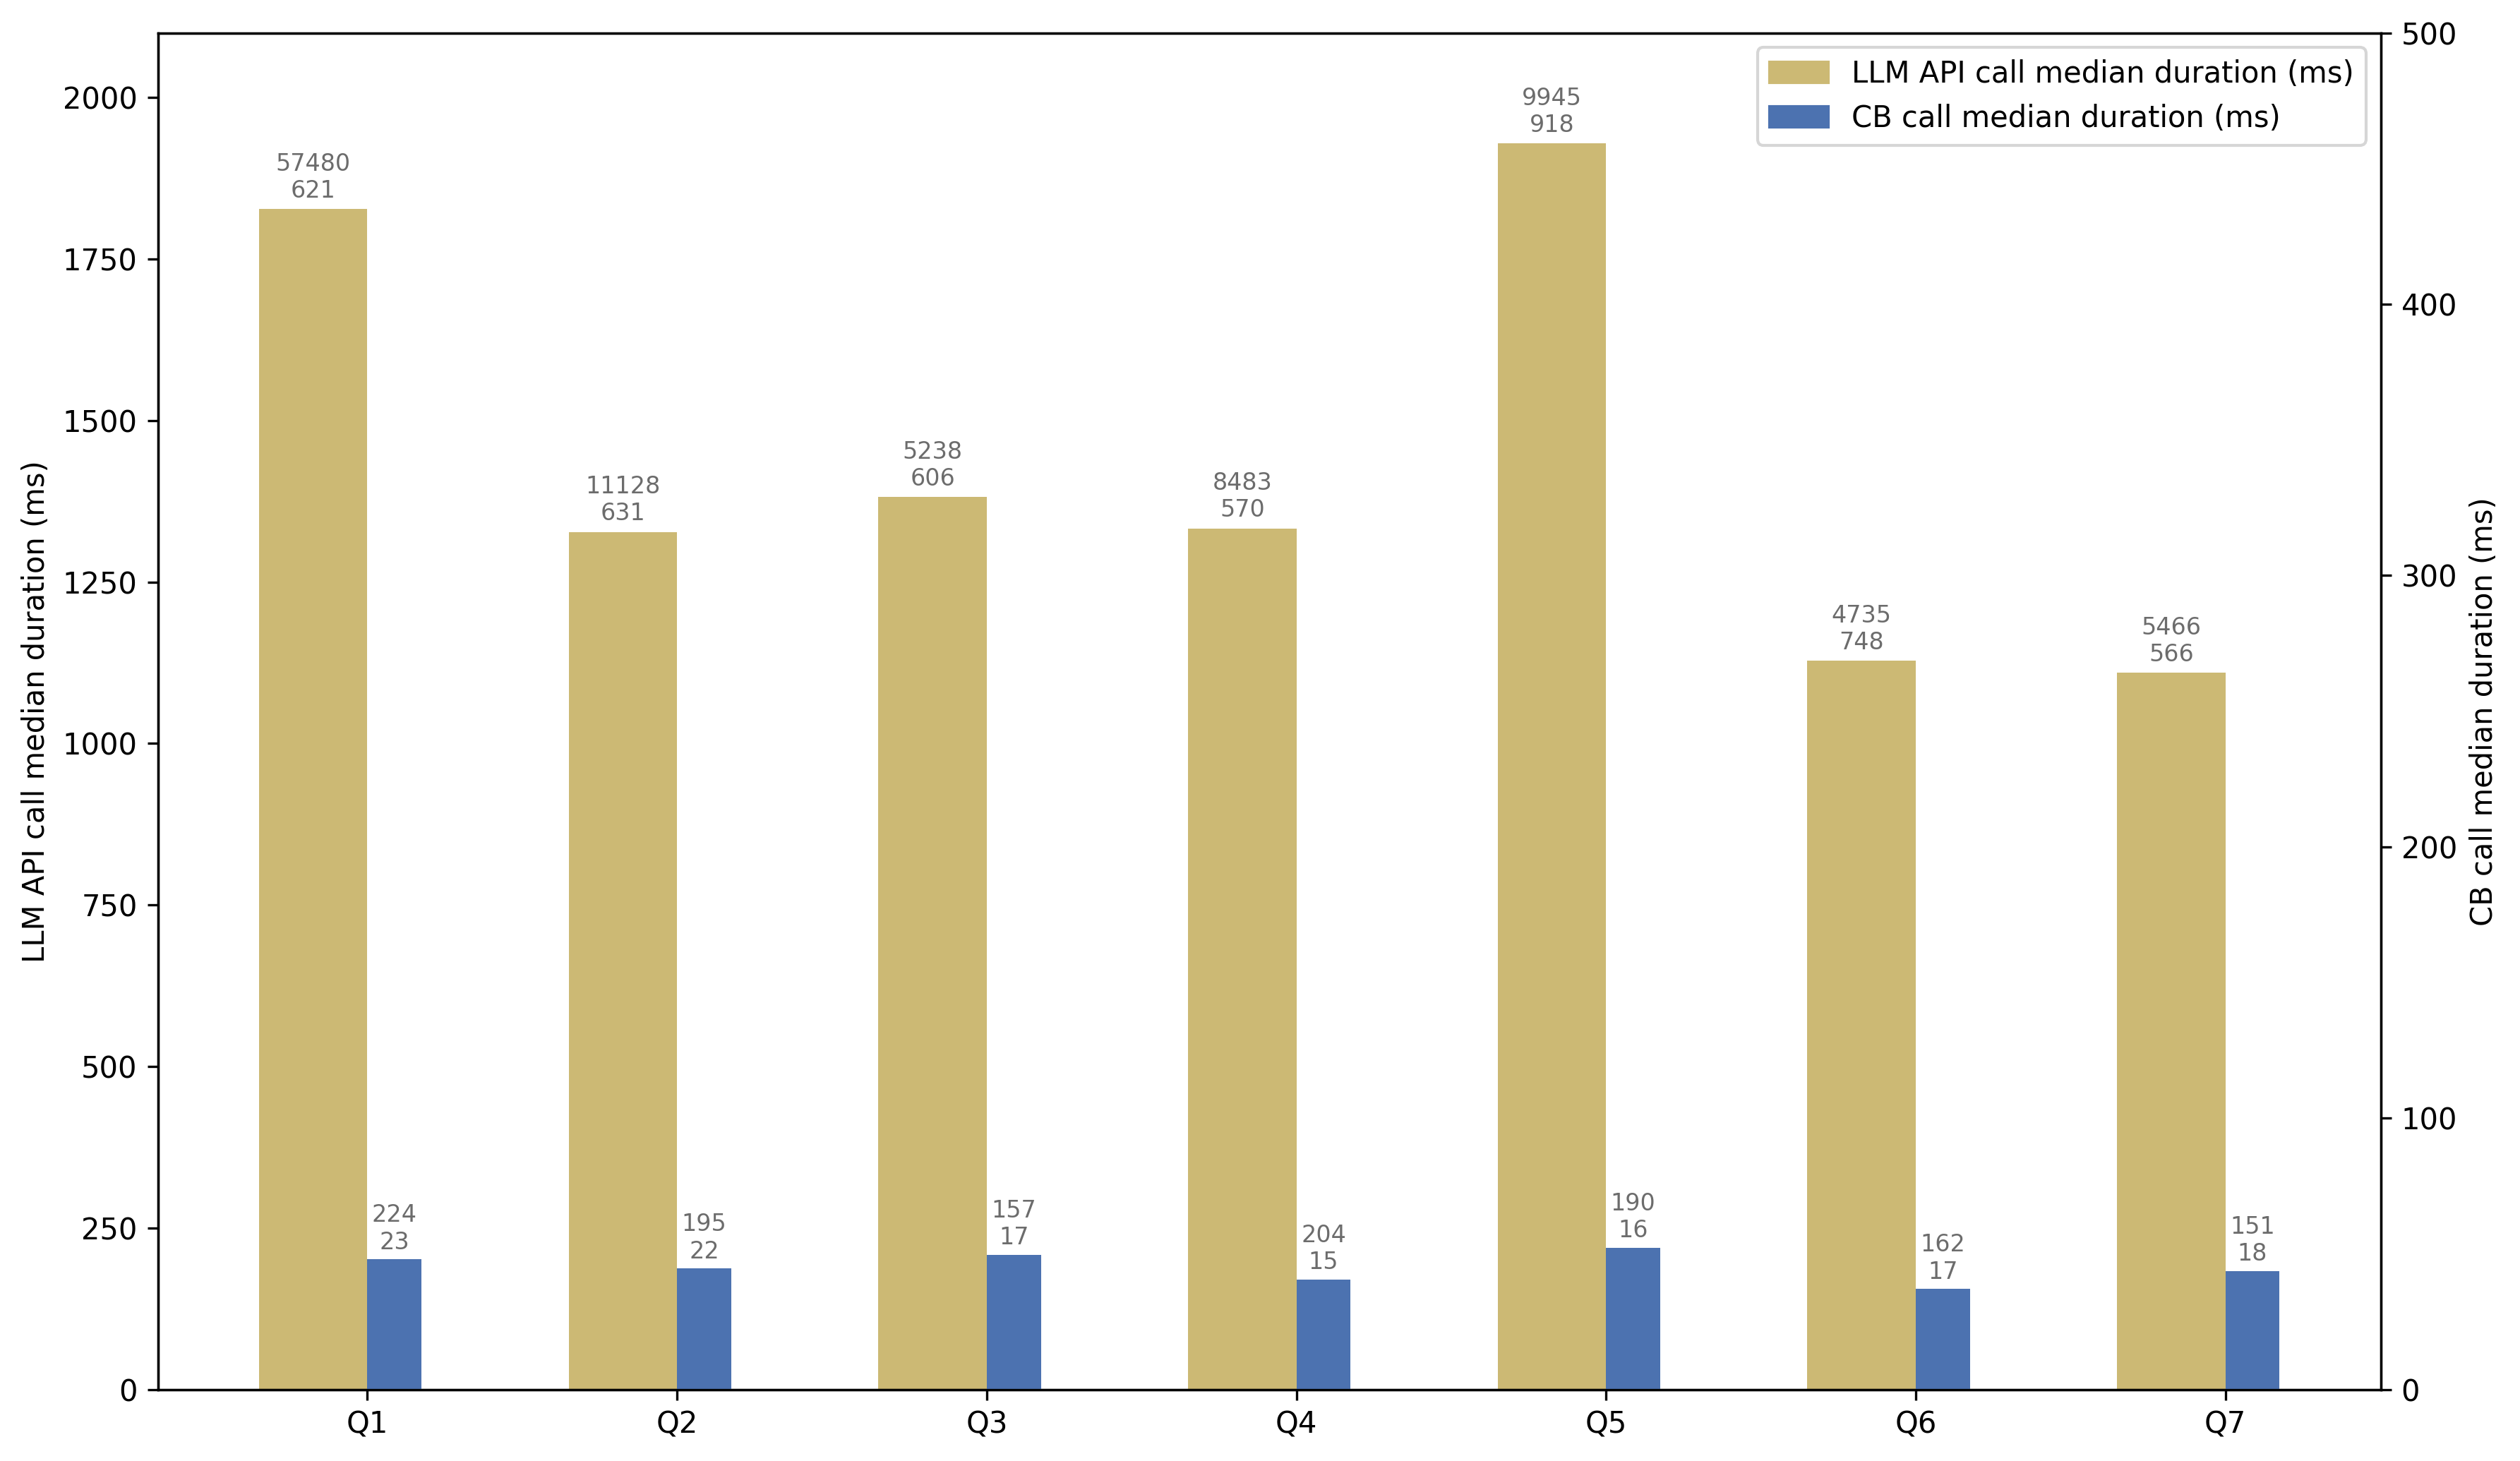

In [4]:
from matplotlib.ticker import FixedLocator, FormatStrFormatter

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
colors = ['#CCB974', '#4C72B0', '#6C6C6C']

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot LLM durations with error bars
bars1 = ax1.bar(x - width/2, grouped['llm_median'], width*1, capsize=11,
                label='LLM API call median duration (ms)', color=colors[0])
ax1.set_ylabel('LLM API call median duration (ms)')
ax1.set_ylim(0, 2100);
ax1.set_xticks(x)
ax1.set_xticklabels([f"Q{i+1}" for i in x], rotation=0)
ax1.set_title("")

# Plot CB durations with error bars on a secondary axis
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/4, grouped['cb_median'], width*0.5, capsize=11,
                label='CB call median duration (ms)', color=colors[1])
ax2.set_ylabel('CB call median duration (ms)')
ax2.set_ylim(0, 500);


####
# Add annotations: LLM min/max
for idx in x:
    llm_min = grouped_minmax.loc[idx, 'llm_min']
    llm_max = grouped_minmax.loc[idx, 'llm_max']
    ax1.text(idx - width/2, grouped.loc[idx, 'llm_median'] + 10, 
             f"{int(llm_max)}\n{int(llm_min)}", 
             ha='center', va='bottom', fontsize=8, rotation=0, color=colors[2])

# Add annotations: CB min/max (scaled back to real values for clarity)
for idx in x:
    cb_min = grouped_minmax.loc[idx, 'cb_min']
    cb_max = grouped_minmax.loc[idx, 'cb_max']
    ax2.text(idx + width/4, grouped.loc[idx, 'cb_median'] + 2, 
             f"{int(cb_max)}\n{int(cb_min)}", 
             ha='center', va='bottom', fontsize=8, rotation=0, color=colors[2])
####


# Create custom legend
legend_labels = [plt.Rectangle((0, 0), 1, 1, color=colors[0]),
                 plt.Rectangle((0, 0), 1, 1, color=colors[1])]
ax1.legend(legend_labels, ['LLM API call median duration (ms)', 'CB call median duration (ms)'], loc='upper right')
plt.tight_layout()
fig.set_dpi(300)
plt.savefig('LLM41_CB_median_times.png', dpi=300)
plt.show()




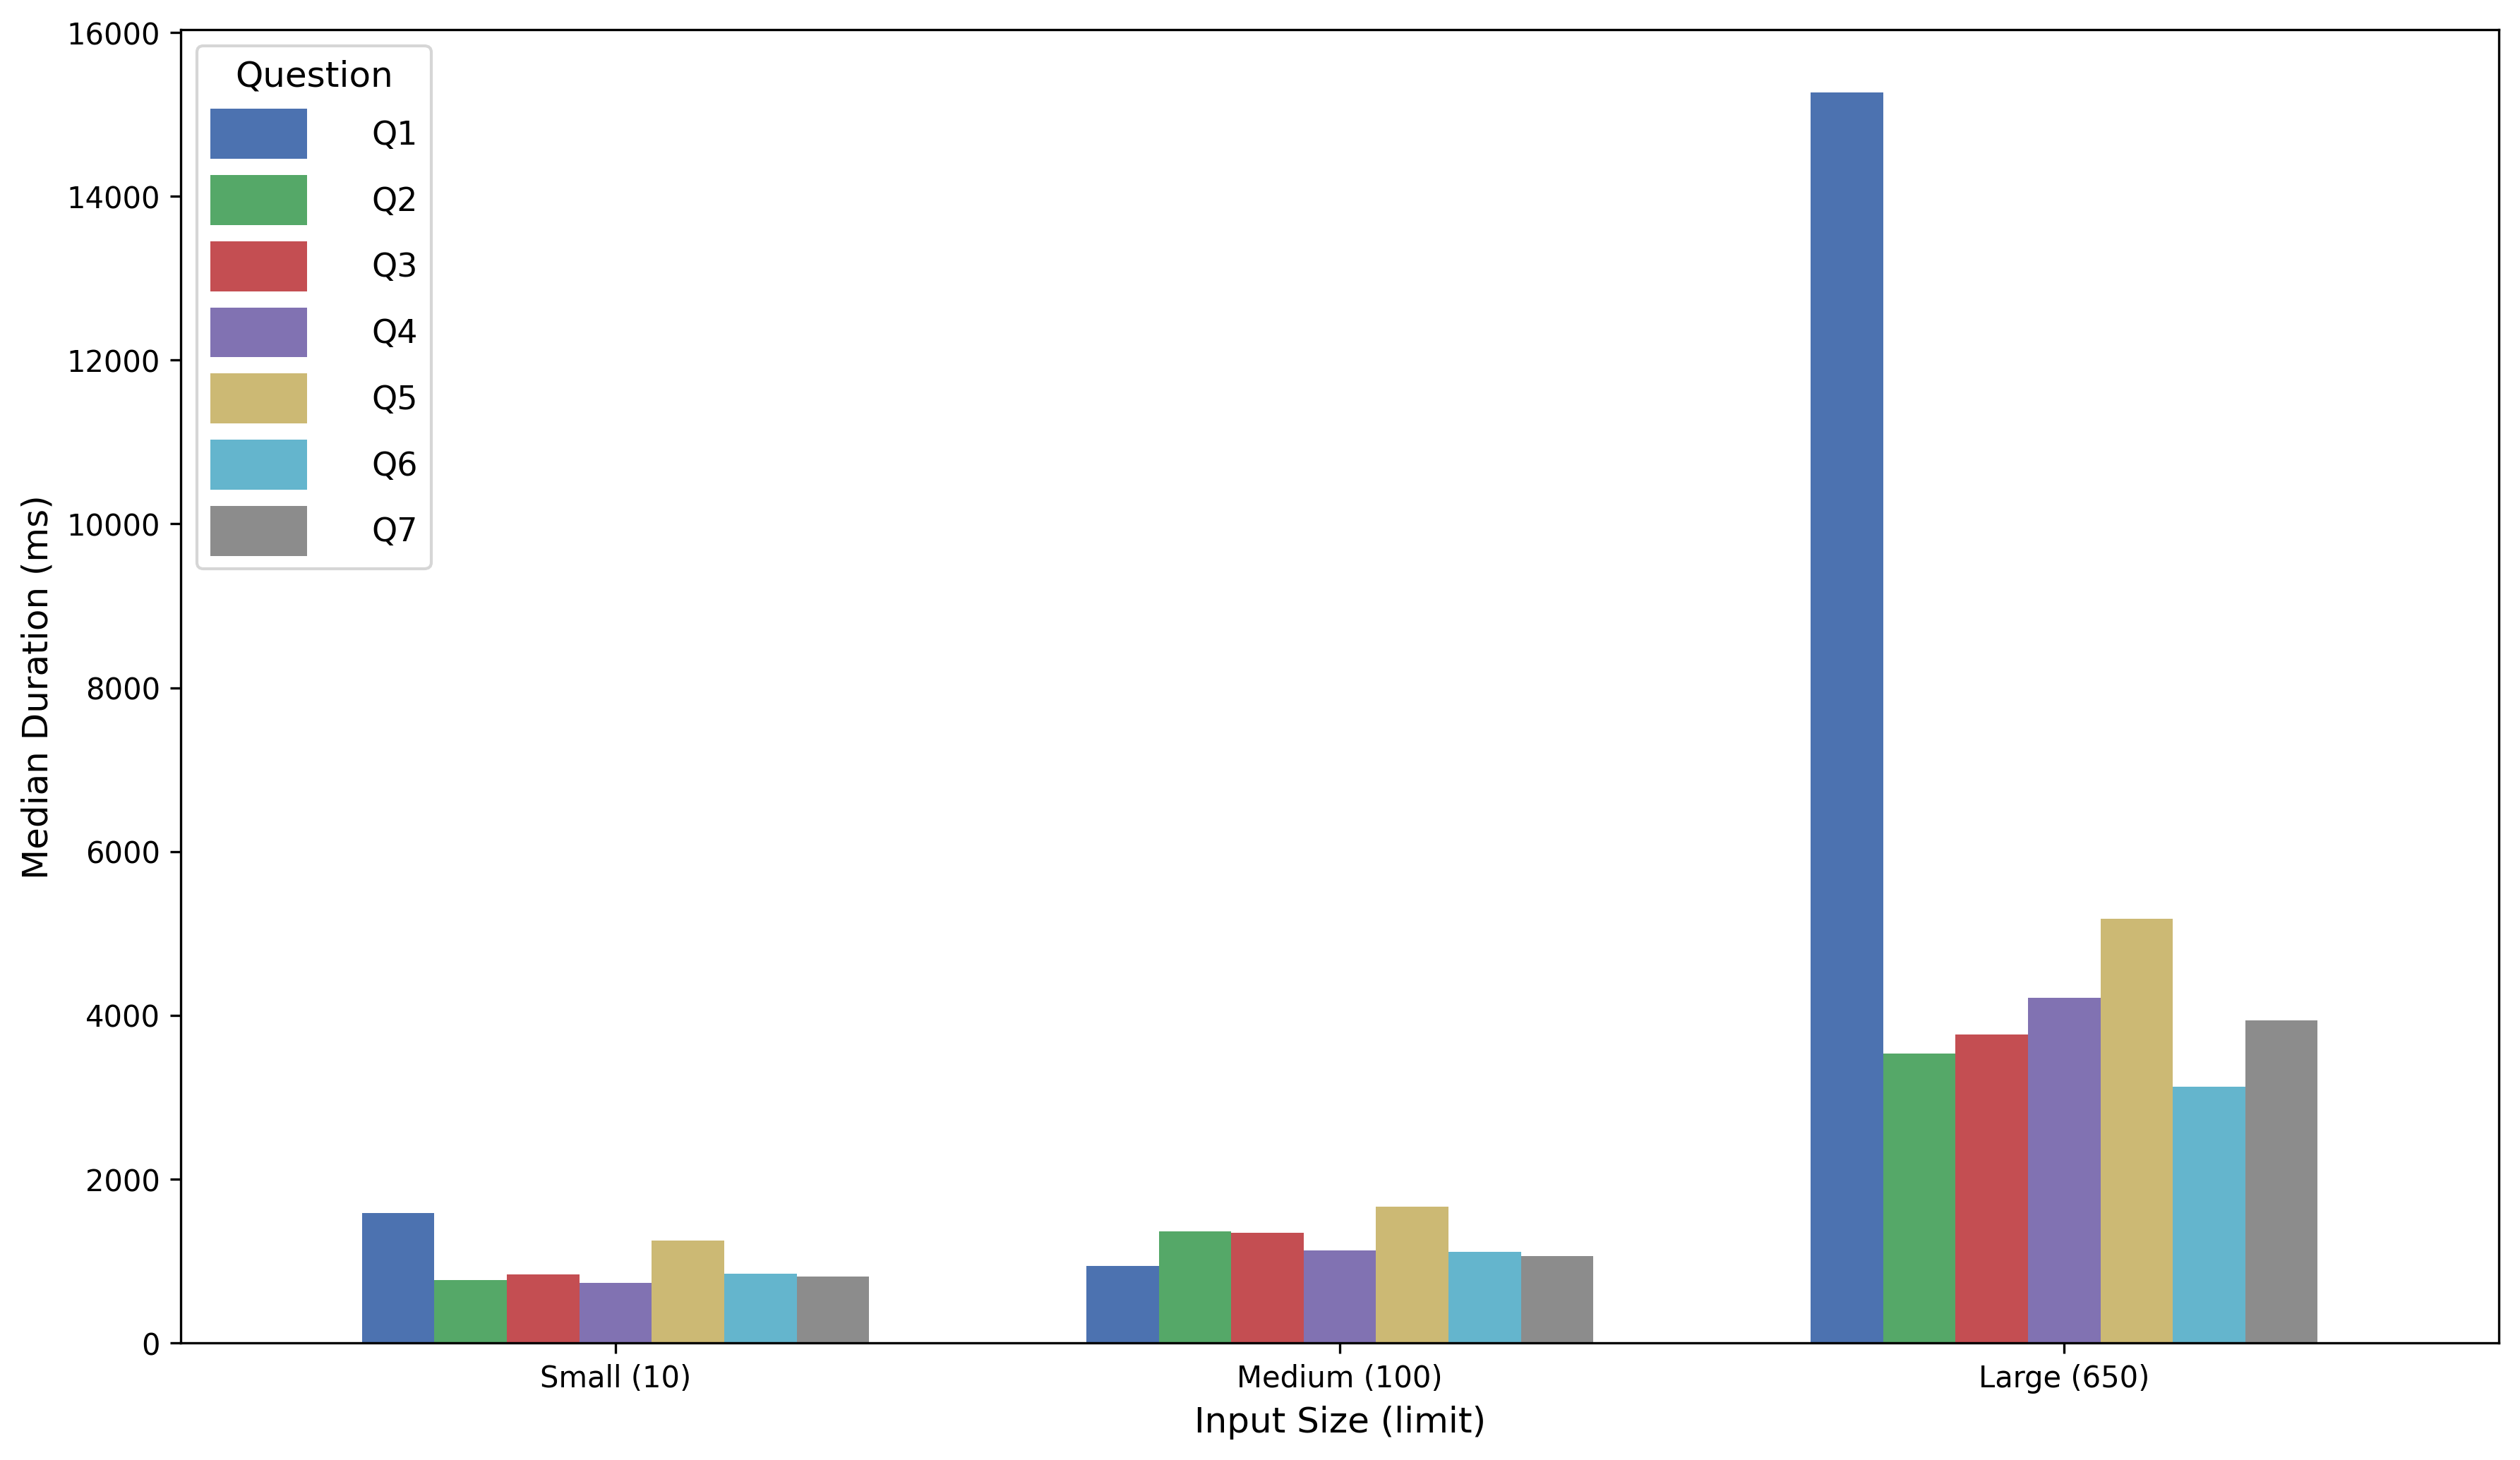

In [5]:
# Calculate the total duration (LLM + CB)
df['total_duration'] = df['duration_GPT4.1 (ms)'] + df['durationCB']

# Group by prompt and limit
grouped_total = df.groupby(['q_number', 'limit'])['total_duration'].median().reset_index()

# Map prompts to questions Q1, Q2, etc.
prompt_to_q = {prompt: f"Q{i+1}" for i, prompt in enumerate(grouped_total['q_number'].unique())}
grouped_total['question'] = grouped_total['q_number'].map(prompt_to_q)

# Pivot for plotting
pivot = grouped_total.pivot(index='limit', columns='question', values='total_duration')
pivot = pivot.reindex([10, 100, 650])

# Custom colors with high contrast
colors = ['#4C72B0', '#55A868', '#C44E52',
          '#8172B2', '#CCB974', '#64B5CD', '#8C8C8C']
# Define hatches (patterns)
#hatches = ['/', '\\', '|', '-', '+', 'x', 'o']

# Create plot
fig, ax = plt.subplots(figsize=(12, 7))


bars = pivot.plot(kind='bar', ax=ax, color=colors, width=0.7)

# Apply hatch patterns
#for i, bar_group in enumerate(ax.containers):
#    for bar in bar_group:
#        bar.set_hatch(hatches[i])

# Customize labels and title
ax.set_title('', fontsize=16)
ax.set_xlabel('Input Size (limit)', fontsize=12)
ax.set_ylabel('Median Duration (ms)', fontsize=12)
ax.set_xticklabels(['Small (10)', 'Medium (100)', 'Large (650)'], rotation=0)
ax.legend(
    title='Question',
    title_fontsize=12,  # Bigger title
    fontsize=11,        # Bigger items
    handleheight=2,   # Taller handles to better show patterns
    handlelength=3,     # Longer symbol
    handletextpad=2,  # More space between symbol and text
    loc='upper left'    # (optional) move it to a more visible place
)

plt.tight_layout()
plt.savefig('LLM41_CB_median_durations_dissagregated.png', dpi=300)
plt.show()